# Monotone schemes with a first order non-linearity, in two space dimensions

This notebook illustrates the use of monotone finite difference schemes to compute viscosity solutions of non-linear PDEs, in two space dimensions. 
We consider the PDE
$$
    -{\rm tr}(A(x) \nabla^2 u(x)) + \| \nabla u(x) -\omega(x)\|^2_{D(x)} - 1 = 0,
$$
with Dirichlet boundary conditions, where $\|v\|_D^2 := <v,D v>$. More details on this problem below.

Two possibilities are considered for the discretization of the first order non-linear (quadratic) term, in a monotone fashion. On is second order accurate, but requires the diffusion tensors $A$ to be positive definite, and the solution to be smooth enough, for monotony to hold. The other possibility is only first order accurate, but unconditionally monotone.

Our numerical schemes use adaptive stencils, and depend on Selling's decomposition of the diffusion tensors $A$ and $D$. Their implementation is fairly simple and compact (approx. ten lines) thanks to the use of automatic differentiation.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.append("..") # Allow import from parent directory
from NumericalSchemes import Selling
from NumericalSchemes import LinearParallel as lp
from NumericalSchemes import FiniteDifferences as fd
spad = fd.spAD # Alternatively : from NumericalSchemes import SparseAutomaticDifferentiation as spad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg; import scipy.sparse; import scipy.sparse.linalg 

Some utility functions

In [52]:
def LInfNorm(a):
    return np.max(np.abs(a))

def as_field(u,shape):
    ndim = len(shape)
    if u.ndim>=ndim and u.shape[-ndim:]==shape: return u
    else: return spad.broadcast_to(u.reshape(u.shape+(1,)*ndim), u.shape+shape)

In [122]:
def solve_residue(res):
    return - scipy.sparse.linalg.spsolve(
        scipy.sparse.coo_matrix(res.triplets()).tocsr(),
        res.value.flatten()).reshape(res.shape)

def solve(Scheme,params,guess,print_period=1,niter=8,relax=0.):
    u = spad.identity(guess.shape)+guess
    for i in range(niter):
        residue = Scheme(u,*params)
        if (i-1)%print_period ==0  or i==niter-1:
            print("Iteration :",i,", Residue norm :", LInfNorm(residue.value)) # Before solve
        u.value += solve_residue(residue + relax)
    return u.value

In [155]:
import importlib
fd = importlib.reload(fd)
spad = importlib.reload(spad)
lp = importlib.reload(lp)
Selling = importlib.reload(Selling)

## 1. A non-linear first order term

We consider the PDE
$$
    -{\rm tr}(A(x) \nabla^2 u(x)) + \| \nabla u(x) -\omega(x)\|^2_{D(x)} - 1 = 0,
$$
with Dirichlet boundary conditions, where $\|v\|_D^2 := <v,D v>$.

Two cases must be distinguished:
* If $A$ is positive definite, then $D$ may be arbitrary (possibly even negative), and we can use a centered finite difference scheme for the first order term. The scheme is then second order consistent and monotone, provided $A \succeq h {\rm Id}$ and $D,\omega = {\mathcal O}(1)$.
* If $A$ vanishes, on part or all of the domain, then we need to assume that $D$ is positive definite, and use an upwind finite difference scheme for the first order term. The scheme is then first order consistent and monotone.

More precisely, consider a decomposition of the form
$$
    A(x) = \sum_{1 \leq i \leq n} \mu_i(x) e_i(x) e_i(x)^T,
$$
where $\mu_i(x)\geq 0$ and $e_i(x)$ has integer entries. (One needs to assume that the condition number of $A(x)$ is bounded.)

**The centered finite differences scheme,** reads 
$$
    -\sum_{1 \leq i \leq n} \mu_i(x) \frac{u(x+he_i(x)) - 2 u(x) +u(x-h e_i(x))}{h^2}
    + \sum_{1 \leq i \leq n} \nu_i(x) \left(\frac{u(x+h e_i(x))-u(x-h e_i(x))}{2 h} - <\omega(x),e_i(x)>\right)^2
    -1
$$
where 
$$
    D(x) = \sum_{1 \leq i \leq n} \nu_i(x) e_i(x) e_i(x)^T
$$
is a tensor decomposition over the same stencil as $A(x)$, but with possibly negative weights $\nu_i(x)$. 

**The upwind finite differences scheme,** reads
$$
    -\sum_{1 \leq i \leq n} \mu_i(x) \frac{u(x+he_i(x)) - 2 u(x) +u(x-h e_i(x))}{h^2}
    + \sum_{1 \leq i \leq n} \nu_i(x) \max\left\{0,
    <\omega(x),f_i(x)> - \frac{u(x+h f_i(x))-u(x)}{h},
    -<\omega(x),f_i(x)> - \frac{u(x-h f_i(x))-u(x)}{h}
    \right\}^2
    -1
$$

In [100]:
def SchemeCentered(u,A,omega,D,bc,h):
    # Compute the decompositions (here offset_e = offset_f)
    sb = Selling.ObtuseSuperbase(A) 
    mu,offset_e = Selling.Decomposition(A,sb=sb)
    nu,offset_f = Selling.Decomposition(D,sb=sb)
    omega_f = lp.dot_VA(omega,offset_f.astype(float))

    # Scheme in the interior
    mu,nu,omega_f = (as_field(spad.cast_left_operand(e,u),u.shape) for e in (mu,nu,omega_f)) 
    residue = ( - (mu*fd.Diff2(u,offset_e,h)).sum(0)
               +(nu*(fd.DiffCentered(u,offset_f,h) - omega_f)**2).sum(0)
              -1.)

    # Boundary conditions
    boundary = np.logical_not(np.isnan(bc))
    residue[boundary] = u[boundary]-bc[boundary] 
    return residue

def SchemeUpwind(u,A,omega,D,bc,h,padding=0):
    # Compute the decompositions (here offset_e = offset_f)
    nothing = (np.full((0,),0.), np.full((2,0),0)) # empty coefs and offsets
    mu,offset_e = nothing if A is None else Selling.Decomposition(A) 
    nu,offset_f = nothing if D is None else Selling.Decomposition(D)
    omega_f = lp.dot_VA(omega,offset_f.astype(float))
    
    # Scheme in the interior
    maxi = spad.maximum
    mu,nu,omega_f = (as_field(spad.cast_left_operand(e,u),u.shape) for e in (mu,nu,omega_f))
    residue = ( - (mu*fd.Diff2(u,offset_e,h,padding=padding)).sum(0)
               +(nu*maxi(0.,maxi( omega_f - fd.DiffUpwind(u, offset_f,h,padding=padding), 
                                 -omega_f - fd.DiffUpwind(u,-offset_f,h,padding=padding)) 
                        )**2
                ).sum(0)
              -1.)
    
    # Boundary conditions
    boundary = np.logical_not(np.isnan(bc))
    residue[boundary] = u[boundary]-bc[boundary] 
    return residue

We next choose some problem parameters. As a starter we solve 
$$
    -\epsilon \Delta u +\| \nabla u\|^2 -1 = 0,
$$
with on the square unit disk $B(0,1)$, with null boundary conditions.
This is a a relaxation of the eikonal equation, and the solution is therefore close to the distance to the disk boundary.

In [83]:
# Create the domain
gridScale = 0.02
aX0 = np.arange(-1,1,gridScale); aX1=aX0;
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')

guess = np.zeros_like(X0) # A correctly shaped arbitrary guess for the solvers

In [60]:
A = 0.1*np.array( ((1,0),(0,1)) )
omega = np.array( (0,0) )
D = np.array( ((1,0),(0,1)) )

bc = np.zeros_like(X0)
bc[X0**2+X1**2<=1] = np.nan

In [64]:
params = (A,omega,D,bc,gridScale)
print("Centered discretization"); 
solution_centered = solve(SchemeCentered,params,guess,print_period=2)
print()
print("Upwind discretization");   
solution_upwind = solve(SchemeUpwind,params,guess,print_period=2)

Centered discretization
Iteration : 1 , Residue norm : 32.076170531724784
Iteration : 3 , Residue norm : 1.618354153184753
Iteration : 5 , Residue norm : 0.004924899868659072
Iteration : 7 , Residue norm : 3.0020430585864233e-13

Upwind discretization
Iteration : 1 , Residue norm : 36.68395708504851
Iteration : 3 , Residue norm : 1.8842589440824922
Iteration : 5 , Residue norm : 0.0062981872978271625
Iteration : 7 , Residue norm : 6.690203946391193e-13


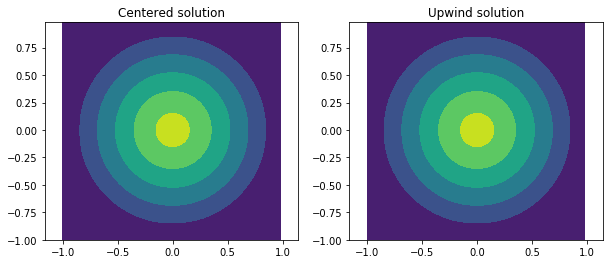

In [81]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.axis('equal'); plt.title('Centered solution')
plt.contourf(X0,X1,solution_centered);
plt.subplot(1,2,2); plt.axis('equal'); plt.title('Upwind solution')
plt.contourf(X0,X1,solution_upwind);

We introduce a drift term $\omega$. While $|\omega|<1$, the deterministic optimal control problem corresponding to $\|\nabla u - \omega\|=1$ remains locally controllable. The solution is smooth enough that the centered scheme remains monotone, and the two solutions agree.

In [94]:
drift_direction = np.array( (1,1) )/np.sqrt(2)

Centered discretization
Iteration : 1 , Residue norm : 25.40778231592474
Iteration : 3 , Residue norm : 0.6773584986005925
Iteration : 5 , Residue norm : 1.0872860567445741e-07
Iteration : 7 , Residue norm : 8.570921750106208e-14

Upwind discretization
Iteration : 1 , Residue norm : 23.526024909771685
Iteration : 3 , Residue norm : 0.7461366808818584
Iteration : 5 , Residue norm : 2.614337794693e-06
Iteration : 7 , Residue norm : 7.527312106958561e-14


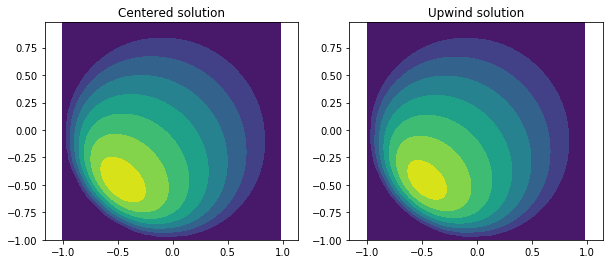

In [95]:
params = (A,0.8*drift_direction,D,bc,gridScale)
print("Centered discretization"); 
solution_centered = solve(SchemeCentered,params,guess,print_period=2)
print()
print("Upwind discretization");   
solution_upwind = solve(SchemeUpwind,params,guess,print_period=2)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.axis('equal'); plt.title('Centered solution')
plt.contourf(X0,X1,solution_centered);
plt.subplot(1,2,2); plt.axis('equal'); plt.title('Upwind solution')
plt.contourf(X0,X1,solution_upwind);

On the other hand, if $|\omega|>1$, then the solution features a boundary layer, along which the gradient norm is large. As a result, the centered scheme looses monotonicity, and cannot the solver fails. 

Centered discretization
Iteration : 1 , Residue norm : 35.05575242835815
Iteration : 3 , Residue norm : 4.973488767825273
Iteration : 5 , Residue norm : 17.92993559133636
Iteration : 7 , Residue norm : 13.055865397360293
Iteration : 9 , Residue norm : 31.536527787858518
Iteration : 11 , Residue norm : 12.172581287909594

Upwind discretization
Iteration : 1 , Residue norm : 19.389258632540034
Iteration : 3 , Residue norm : 0.0038638518425955226
Iteration : 5 , Residue norm : 9.769962616701378e-14
Iteration : 7 , Residue norm : 8.748557434046234e-14


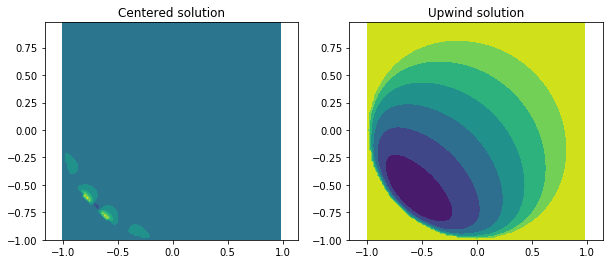

In [96]:
params = (A,1.2*drift_direction,D,bc,gridScale)
print("Centered discretization"); 
solution_centered = solve(SchemeCentered,params,guess,print_period=2,niter=12)
print()
print("Upwind discretization");   
solution_upwind = solve(SchemeUpwind,params,guess,print_period=2)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.axis('equal'); plt.title('Centered solution')
plt.contourf(X0,X1,solution_centered);
plt.subplot(1,2,2); plt.axis('equal'); plt.title('Upwind solution')
plt.contourf(X0,X1,solution_upwind);

The upwind scheme is monotone and solvable even for a vanishing diffusion tensor field $A$.

A numerical difficulty arises however for our Newton solver : the jacobian matrix $J$ of the scheme may not be invertible. Fortunately but $J+ \epsilon {\rm Id}$ is invertible for any $\epsilon>0$.

Iteration : 1 , Residue norm : 29.91851777146254
Iteration : 3 , Residue norm : 1.6331529368170683
Iteration : 5 , Residue norm : 0.0166409019440954
Iteration : 7 , Residue norm : 5.512158204434847e-05
Iteration : 9 , Residue norm : 9.078573095511189e-07
Iteration : 11 , Residue norm : 1.0010628548329237e-08


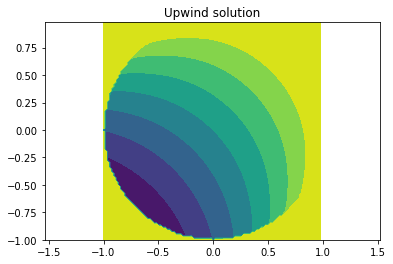

In [103]:
params = (None,1.2*drift_direction,D,bc,gridScale)
epsilon=1; relax = epsilon*spad.identity(X0.shape)
solution_upwind = solve(SchemeUpwind,params,guess,print_period=2,niter=12,relax=relax)

plt.axis('equal'); plt.title('Upwind solution')
plt.contourf(X0,X1,solution_upwind);

For validation purposes, we reproduce the canonical example of a laplacian over a square domain.

Iteration : 0 , Residue norm (before solve) : 1.0


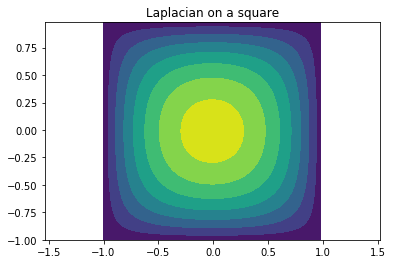

In [125]:
bc_square = np.full(X0.shape,np.nan)
params = (np.eye(2),np.zeros(2),None,bc_square,gridScale)
solution_upwind = solve(SchemeUpwind,params,guess,print_period=2,niter=1)

plt.axis('equal'); plt.title('Laplacian on a square')
plt.contourf(X0,X1,solution_upwind);

### 1.1 Pure eikonal equations

The upwind scheme can accomodate, a null diffusion tensor $A$, so that the consider PDE degenerates to a first order eikonal-like equation. 
$$
    \|\nabla u-\omega\|_D^2-1=0.
$$
In that case we may in addition impose the boundary condition $+\infty$ part of the domain boundary, in the sense of viscosity solutions. This corresponds to outflow boundary conditions.

**Note on the numerical solver.**
In this notebook, we use a Newton-like solver for all the PDEs. While this approach does eventually work for the considered examples, let us emphasize that it *lacks both speed and robustness in the case of pure eikonal equations*. Gauss-Siedel iterations (either sweeping or adaptive) are much more adequate, or even better the single pass fast marching method (applicable to this numerical scheme when $\omega=0$). 

**Stabilization of the linear solves**
The jacobian matrix $J$ of the considered numerical scheme is not invertible, but 
$$
    J + \epsilon_0 {\rm Id} - \epsilon_1 \Delta
$$
is invertible for any $\epsilon_0>0$ and $\epsilon_1\geq 0$, where $\Delta$ is the matrix of the laplacian operator.

We use both $\epsilon_0>0$ and $\epsilon_1>0$ in the first steps of Newton method, to propagate information over the domain using the laplacian kernel. Once a good approximation of the solution is obtained, we turn to a more basis relaxation with $\epsilon_0>0$ and $\epsilon_1=0$.

### A Riemannian eikonal equation
We solve $\|\nabla u\|_D = 1$, where $D$ is the inverse to a Riemannian metric, which is specified in terms of its eigenvalues and eigenvectors.

In order to compute the Riemannian distance from the domain center $x_0$, we impose the Dirichlet boundary condition $u(x_0)=0$. On the domain boundary, we set $u=+\infty$ in the sense of viscosity solutions, to impose outflow boundary conditions.

In [169]:
ident = spad.identity(X0.shape)
lap   = fd.Diff2(ident,(1,0),gridScale) + fd.Diff2(ident,(0,1),gridScale)
lap[0,:]=0.; lap[-1,:]=0.; lap[:,0]=0.; lap[:,-1]=0.; 

In [157]:
# Generate the metric
eig1 = np.stack((np.full(X0.shape,1.),(np.pi/2)*np.cos(2*np.pi*X0)))
eig1 /= scipy.linalg.norm(eig1,axis=0) 
eig2 = np.stack( (eig1[1],-eig1[0]) ) # Rotate eig1 by pi/2
lambda1, lambda2 = 0.8, 0.2
metric = lambda1**-2*lp.outer_self(eig1) + lambda2**-2*lp.outer_self(eig2)

# Use a seed in the center
bc_center = np.full(X0.shape,np.nan)
bc_center[X0.shape[0]//2,X0.shape[1]//2] = 1

# Outflow boundary conditions on the boundary
padding=np.inf 

In [ ]:
# Set the problem parameters
D_Riemann = lp.inverse(metric)
omega_Riemann = as_field(np.zeros(2),X0.shape)

Iteration : 1 , Residue norm (before solve) : 1.0
Iteration : 5 , Residue norm (before solve) : 3.6078022770426053
Iteration : 9 , Residue norm (before solve) : 176.18722032194393
Iteration : 13 , Residue norm (before solve) : 4.3716506278712295
Iteration : 17 , Residue norm (before solve) : 2.882099500504961
Iteration : 19 , Residue norm (before solve) : 2.1484241810174773

Iteration : 1 , Residue norm (before solve) : 10.71205372098724
Iteration : 5 , Residue norm (before solve) : 0.33991427636277183
Iteration : 9 , Residue norm (before solve) : 0.02609673206337071
Iteration : 13 , Residue norm (before solve) : 0.0017083302612956874
Iteration : 17 , Residue norm (before solve) : 0.00010718314095670145
Iteration : 19 , Residue norm (before solve) : 2.6798148805351474e-05


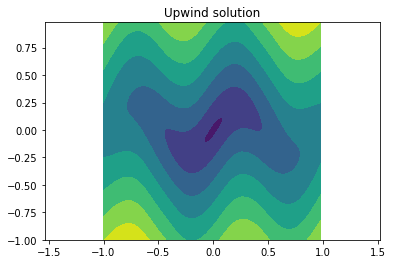

In [168]:
params = (None,omega_Riemann,D_Riemann,bc_center,gridScale,padding)
solution_upwind = solve(SchemeUpwind,params,guess, # Zero guess
                       print_period=4,niter=20,relax=ident-gridScale*lap) # Laplacian in relaxation

print()
solution_upwind = solve(SchemeUpwind,params,solution_upwind, # Previous solution as guess
                       print_period=4,niter=20,relax=ident) # Basic relaxation

plt.axis('equal'); plt.title("Riemannian eikonal equation")
plt.contourf(X0,X1,solution_upwind);

### An eikonal equation of Rander type

We solve a classical instance of Zermelo's navigation problem: $u(x)=T$ is the smallest time for which there exists a path $\gamma : [0,T] \to \Omega$ such that 
$$
    \| \gamma'(t) - \eta(\gamma(t))\|_{M(\gamma(t))} \leq 1
$$
for all $0 \leq t \leq T$, and with the endpoint conditions $\gamma(0) = x_0$ (the seed point) and $\gamma(T)=x$.
Here $M$ is a prescribed Riemannian metric, and $\eta$ is a drift vector field. 

For well posedness, we require the problem to be locally controllable, which is the case provided 
$$
\| \eta(x)\|_{M(x)} < 1
$$
at all points of the domain.

In [178]:
# Choose the Riemannian metric and drift
metric = as_field( np.eye(2), X0.shape)
drift_max_speed = 0.8
drift = drift_max_speed*np.sin(2*np.pi*X0)*np.sin(2*np.pi*X1) * np.stack((X0,X1))/ np.sqrt(X0**2+X1**2)

In [ ]:
def RanderDual(m,v):
    s = lp.inverse(m-lp.outer_self(v))
    w = lp.dot_AV(s,v)
    return (s*(1+lp.dot_VV(v,w)),w)

In [179]:
# Set the problem parameters
D_Rander,omega_Rander = RanderDual(lp.inverse(metric),drift)
D_Rander = lp.inverse(D_Rander)

Iteration : 1 , Residue norm (before solve) : 3.429512041511205
Iteration : 5 , Residue norm (before solve) : 714.2666354623406
Iteration : 9 , Residue norm (before solve) : 8.191505580655384
Iteration : 13 , Residue norm (before solve) : 0.6922664402124337
Iteration : 17 , Residue norm (before solve) : 0.23840958690332226
Iteration : 19 , Residue norm (before solve) : 0.0930021639273263

Iteration : 1 , Residue norm (before solve) : 0.01167280850189567
Iteration : 5 , Residue norm (before solve) : 0.0010799904129059623
Iteration : 9 , Residue norm (before solve) : 6.695664115574651e-05
Iteration : 13 , Residue norm (before solve) : 4.184358700864976e-06
Iteration : 17 , Residue norm (before solve) : 2.615226311064589e-07
Iteration : 19 , Residue norm (before solve) : 6.538066354977445e-08


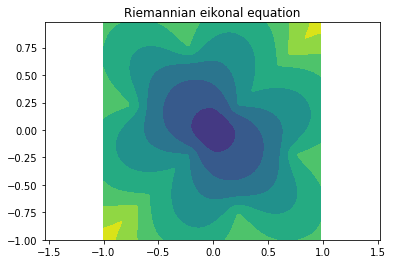

In [180]:
params = (None,omega_Rander,D_Rander,bc_center,gridScale,padding)
solution_upwind = solve(SchemeUpwind,params,guess, # Zero guess
                       print_period=4,niter=20,relax=ident-gridScale*lap) # Laplacian in relaxation

print()
solution_upwind = solve(SchemeUpwind,params,solution_upwind, # Previous solution as guess
                       print_period=4,niter=20,relax=ident) # Basic relaxation

plt.axis('equal'); plt.title("Rander eikonal equation")
plt.contourf(X0,X1,solution_upwind);